# Rodrigo Mendoza Rodriguez Examen

In [6]:
import zipfile
from pathlib import Path

base = Path.cwd().parent
path_zip = base / 'author_profiling_pan.zip'
with zipfile.ZipFile(path_zip, "r") as z:
    z.extractall("carpeta_docs")

In [7]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stop_words = set(stopwords.words("spanish"))
tokenizer = TweetTokenizer()


def limpiar_texto(texto):
    texto = BeautifulSoup(texto, "html.parser").get_text()
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#+", "", texto)
    return texto


In [8]:
import os
import xml.etree.ElementTree as ET
def get_texts_from_folder(path_folder):
    tr_txt = []  # aquí van los documentos
    tr_y = []    # aquí van las etiquetas

    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(path_folder, file))
            root = tree.getroot()
            docs = []
            for doc in root.iter("document"):
                texto_limpio = limpiar_texto(doc.text)
                if texto_limpio:  #
                    docs.append(texto_limpio)
            if docs:
                tr_txt.append(" ".join(docs))

    truth_file = os.path.join(path_folder, "truth.txt")
    if os.path.exists(truth_file):
        file_to_label = {}
        with open(truth_file, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(":::")
                if len(parts) >= 3:
                    file_to_label[parts[0]] = parts[1]

        for file in os.listdir(path_folder):
            if file.endswith(".xml"):
                file_id = file.split('.')[0]
                if file_id in file_to_label:
                    tr_y.append(file_to_label[file_id])

    return tr_txt, tr_y

In [9]:
path_test = 'carpeta_docs/author_profiling_pan/es_test/'
path_train = 'carpeta_docs/author_profiling_pan/es_train/'
tr_txt_train, tr_y_train = get_texts_from_folder(path_train)

print(f"\nTextos train: {len(tr_txt_train)}, Etiquetas train: {len(tr_y_train)}")

paises = sorted(list(set(tr_y_train)))
paises_numericas = {pais: idx for idx, pais in enumerate(paises)}

y_train = [paises_numericas[pais] for pais in tr_y_train]


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_18612\3663305902.py:11: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()



Textos train: 4200, Etiquetas train: 4200


In [10]:
import nltk
corpus_de_palabras = []
for doc in tr_txt_train:
    if doc and isinstance(doc, str):
        corpus_de_palabras += tokenizer.tokenize(doc)
corpus_de_palabras = [token for token in corpus_de_palabras if re.match(r"^[a-zA-ZáéíóúÁÉÍÓÚñÑ]+$", token)]

fdist = nltk.FreqDist(corpus_de_palabras)
V = [word for word, _ in fdist.most_common(10000)]
dict_indices = {word: i for i, word in enumerate(V)}

In [11]:
import numpy as np
def built_bow_tr_binario(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=np.int8)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        for word in tokens:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = 1
    return bow

In [12]:
bow_tr = built_bow_tr_binario(tr_txt_train, V, dict_indices)
bow_tr

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], shape=(4200, 10000), dtype=int8)

# Parte 1

1.1 Construye una Bolsa de Palabras Binaria, normalízala con L2 y evalúa con SVM.

In [13]:
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import normalize

In [14]:
bow_train_L2 = normalize(bow_tr, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_L2, y_train, test_size=0.2, stratify=y_train)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario_l2, rec_bow_binario_l2, f1_bow_binario_l2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[306 114]
 [ 93 327]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       420
           1       0.74      0.78      0.76       420

    accuracy                           0.75       840
   macro avg       0.75      0.75      0.75       840
weighted avg       0.75      0.75      0.75       840



In [15]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_tr, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario, rec_bow_binario, f1_bow_binario, _ = precision_recall_fscore_support(y_val_20, y_pred, average='weighted')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


[[317 103]
 [106 314]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       420
           1       0.75      0.75      0.75       420

    accuracy                           0.75       840
   macro avg       0.75      0.75      0.75       840
weighted avg       0.75      0.75      0.75       840



# Ejercicio 2

In [16]:
import numpy as np
def built_bow_tr_frecuencia(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        fdist_doc = nltk.FreqDist(tokens)
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
    return bow

In [17]:
tokenizer = TweetTokenizer()
corpus_de_palabras_f = []
for doc in tr_txt_train:
    if isinstance(doc, str):
        corpus_de_palabras_f += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_de_palabras_f)

V_f = [word for word, _ in fdist.most_common(10000)]
dict_indices_f = {word: i for i, word in enumerate(V_f)}


In [18]:
bow_train_frecuencia = built_bow_tr_frecuencia(tr_txt_train,V_f,dict_indices_f)
print(bow_train_frecuencia)
bow_train_frecuencia.shape

[[ 54  34  14 ...   0   0   0]
 [ 30  21   3 ...   0   0   0]
 [ 70  48  73 ...   0   0   0]
 ...
 [ 64  11   0 ...   0   0   0]
 [ 83  67  25 ...   0   0   0]
 [ 53  52 107 ...   0   0   0]]


(4200, 10000)

In [19]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia, rec_bow_frecuencia, f1_bow_frecuencia, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


[[320 100]
 [119 301]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       420
           1       0.75      0.72      0.73       420

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.74       840
weighted avg       0.74      0.74      0.74       840



# Ejercicio 3

In [20]:

bow_train_L2 = normalize(bow_tr, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_L2, y_train, test_size=0.2, stratify=y_train)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario_l2, rec_bow_binario_l2, f1_bow_binario_l2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[332  88]
 [ 93 327]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       420
           1       0.79      0.78      0.78       420

    accuracy                           0.78       840
   macro avg       0.78      0.78      0.78       840
weighted avg       0.78      0.78      0.78       840



# Ejercicio 4

In [21]:
bow_train_frecuencia_L2 = normalize(bow_train_frecuencia, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia_L2, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia_L2, rec_bow_frecuencia_L2, f1_bow_frecuencia_L2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[322  98]
 [ 99 321]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       420
           1       0.77      0.76      0.77       420

    accuracy                           0.77       840
   macro avg       0.77      0.77      0.77       840
weighted avg       0.77      0.77      0.77       840



In [25]:
import pandas as pd
def ganador_metricas( etiquetas, precisiones, f1_scores):
    max_prec = max(precisiones)
    max_f1 = max(f1_scores)
    
    if max_prec >= max_f1:
        indice_ganador = precisiones.index(max_prec)
        return etiquetas[indice_ganador], max_prec
    else:
        indice_ganador = f1_scores.index(max_f1)
        return etiquetas[indice_ganador], max_f1


etiquetas = ['BOW Binario', 'BOW Frecuencia', 'BOW Binario + L2', 'BOW Frecuencia + L2' ]



# ======================= Tabla comparativa =======================
tabla_comparativa = {
    'Experimento': etiquetas,
    'Accuracy': [prec_bow_binario, prec_bow_frecuencia, prec_bow_binario_l2, prec_bow_frecuencia_L2,],
    'F1-Score (Macro)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'F1-Score (Weighted)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'Precisión (Macro)': [prec_bow_binario, prec_bow_frecuencia, prec_bow_binario_l2, prec_bow_frecuencia_L2,]
}

df_comparativo = pd.DataFrame(tabla_comparativa)

print("TABLA COMPARATIVA DE LOS 4 EJERCICIOS")
print("=" * 50)
print(df_comparativo)
print("=" * 50)

ganador = ganador_metricas(etiquetas, tabla_comparativa['Precisión (Macro)'], tabla_comparativa['F1-Score (Macro)'])
print(f"Gano el modelo basado en: {ganador[0]} con un valor de: {ganador[1]:.4f}")

TABLA COMPARATIVA DE LOS 4 EJERCICIOS
           Experimento  Accuracy  F1-Score (Macro)  F1-Score (Weighted)  \
0          BOW Binario  0.751203          0.751187             0.751187   
1       BOW Frecuencia  0.739776          0.739152             0.739152   
2     BOW Binario + L2  0.784564          0.784516             0.784516   
3  BOW Frecuencia + L2  0.765478          0.765476             0.765476   

   Precisión (Macro)  
0           0.751203  
1           0.739776  
2           0.784564  
3           0.765478  
Gano el modelo basado en: BOW Binario + L2 con un valor de: 0.7846


# DOR

In [26]:
def compute_dor(TR):
  shapes=TR.shape
  DTR=np.zeros((shapes[1], shapes[0]), dtype=np.float64)
  tam_V=TR.shape[1]

  for doc, i in zip(TR, range(len(TR))): #Iterar por cada documento
    non_zero_positions=np.nonzero(doc)[0] #Numeros de las dimensiones de las palabras contenidas en el tweet
    tam_v=len(non_zero_positions)
    for term in non_zero_positions:
      DTR[term, i] = np.log10(1+doc[term])*np.log10(tam_V/tam_v)
  return DTR

In [27]:
DOR_base = compute_dor(bow_train_frecuencia)
DOR_base.shape

(10000, 4200)

In [28]:
DOR_base

array([[2.41610496, 2.06884102, 2.52607211, ..., 2.49218942, 2.54465355,
        2.25239301],
       [2.14359368, 1.86223041, 2.30630002, ..., 1.48353702, 2.42329705,
        2.24183844],
       [1.63274008, 0.83518734, 2.55059706, ..., 0.        , 1.87115092,
        2.64378085],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(10000, 4200))

In [29]:
DOR_normalizado = normalize(DOR_base, norm='l2')

In [30]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000)

feats.fit(bow_train_frecuencia, y_train)

,"score_func score_func: callable, default=f_classifFunction taking two arrays X and y, and returning a pair of arrays(scores, pvalues) or a single array with scores.Default is f_classif (see below ""See Also""). The default function onlyworks with classification tasks... versionadded:: 0.18",<function chi...002AC0374A340>
,"k k: int or ""all"", default=10Number of top features to select.The ""all"" option bypasses selection, for use in a parameter search.",1000


In [31]:
best = feats.get_support(indices=True)
best

array([   0,    1,    2,    4,    5,    6,    7,    8,    9,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   21,   22,   23,   25,
         26,   27,   28,   29,   31,   35,   37,   38,   39,   40,   41,
         42,   43,   44,   45,   46,   47,   48,   51,   52,   53,   55,
         56,   61,   62,   67,   71,   72,   73,   74,   75,   77,   80,
         82,   85,   86,   87,   88,   91,   95,  100,  102,  103,  106,
        111,  112,  113,  114,  115,  118,  119,  121,  122,  127,  128,
        129,  130,  134,  138,  141,  143,  145,  149,  150,  152,  154,
        158,  161,  162,  166,  169,  170,  171,  173,  179,  180,  181,
        183,  184,  186,  188,  189,  190,  193,  197,  200,  204,  205,
        208,  211,  213,  220,  222,  223,  224,  229,  230,  231,  233,
        234,  235,  238,  241,  243,  244,  247,  250,  251,  253,  254,
        255,  257,  260,  262,  264,  267,  271,  272,  274,  285,  286,
        287,  289,  294,  295,  306,  310,  313,  3

In [32]:
dict_indices_alreves = {}
for palabra, indice in dict_indices.items():
    dict_indices_alreves[indice] = palabra
target_word = [dict_indices_alreves[index] for index in best]
t_words = target_word
t_words

['de',
 'que',
 'la',
 'el',
 'a',
 'en',
 'no',
 'es',
 'los',
 'un',
 'por',
 'se',
 'con',
 'lo',
 'para',
 'del',
 'las',
 'una',
 'mi',
 'si',
 'al',
 'más',
 'pero',
 'ya',
 'q',
 'su',
 'todo',
 'cuando',
 'este',
 'hay',
 'o',
 'vía',
 'hoy',
 'qué',
 'son',
 'eso',
 'muy',
 'ser',
 'está',
 'día',
 'nos',
 'sin',
 'bien',
 'siempre',
 'quiero',
 'ahora',
 'solo',
 'hace',
 'tan',
 'hacer',
 'esto',
 'fue',
 'año',
 'hasta',
 'gente',
 'ese',
 'días',
 'esa',
 'les',
 'mis',
 'd',
 'voy',
 'jajaja',
 'también',
 'mañana',
 'cosas',
 'nuevo',
 'menos',
 'dos',
 'vamos',
 'tiempo',
 'cada',
 'estar',
 'donde',
 'están',
 'país',
 'mismo',
 'x',
 'cómo',
 'eres',
 'ir',
 'tanto',
 'igual',
 'buenos',
 'sí',
 'gobierno',
 'semana',
 'jajajaja',
 'entre',
 'favor',
 'personas',
 'debe',
 'toda',
 'estamos',
 'parece',
 'fin',
 'todas',
 'trabajo',
 'decir',
 'sólo',
 'falta',
 'méxico',
 'tú',
 'grande',
 'quiere',
 'nuevos',
 'ganas',
 'gusta',
 'equipo',
 'final',
 'poder',
 'colo

In [33]:
# dict_indices {palabra : dimension_en_bow}
target_matrix = np.array([DOR_normalizado[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 4200)

In [34]:
from sklearn.manifold import TSNE
 
 
reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)
reduce_matrix

array([[ -3.1326084 ,  -1.2501236 ],
       [ -3.0996    ,  -0.24808587],
       [ -3.5128677 ,  -2.2141855 ],
       ...,
       [-14.461386  ,  34.808914  ],
       [-25.693892  , -24.525331  ],
       [-26.18794   ,  13.566046  ]], shape=(1000, 2), dtype=float32)

In [35]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 42.530948638916016, max_y: 38.368408203125
min_x: -40.01790237426758, min_y: -38.24484634399414


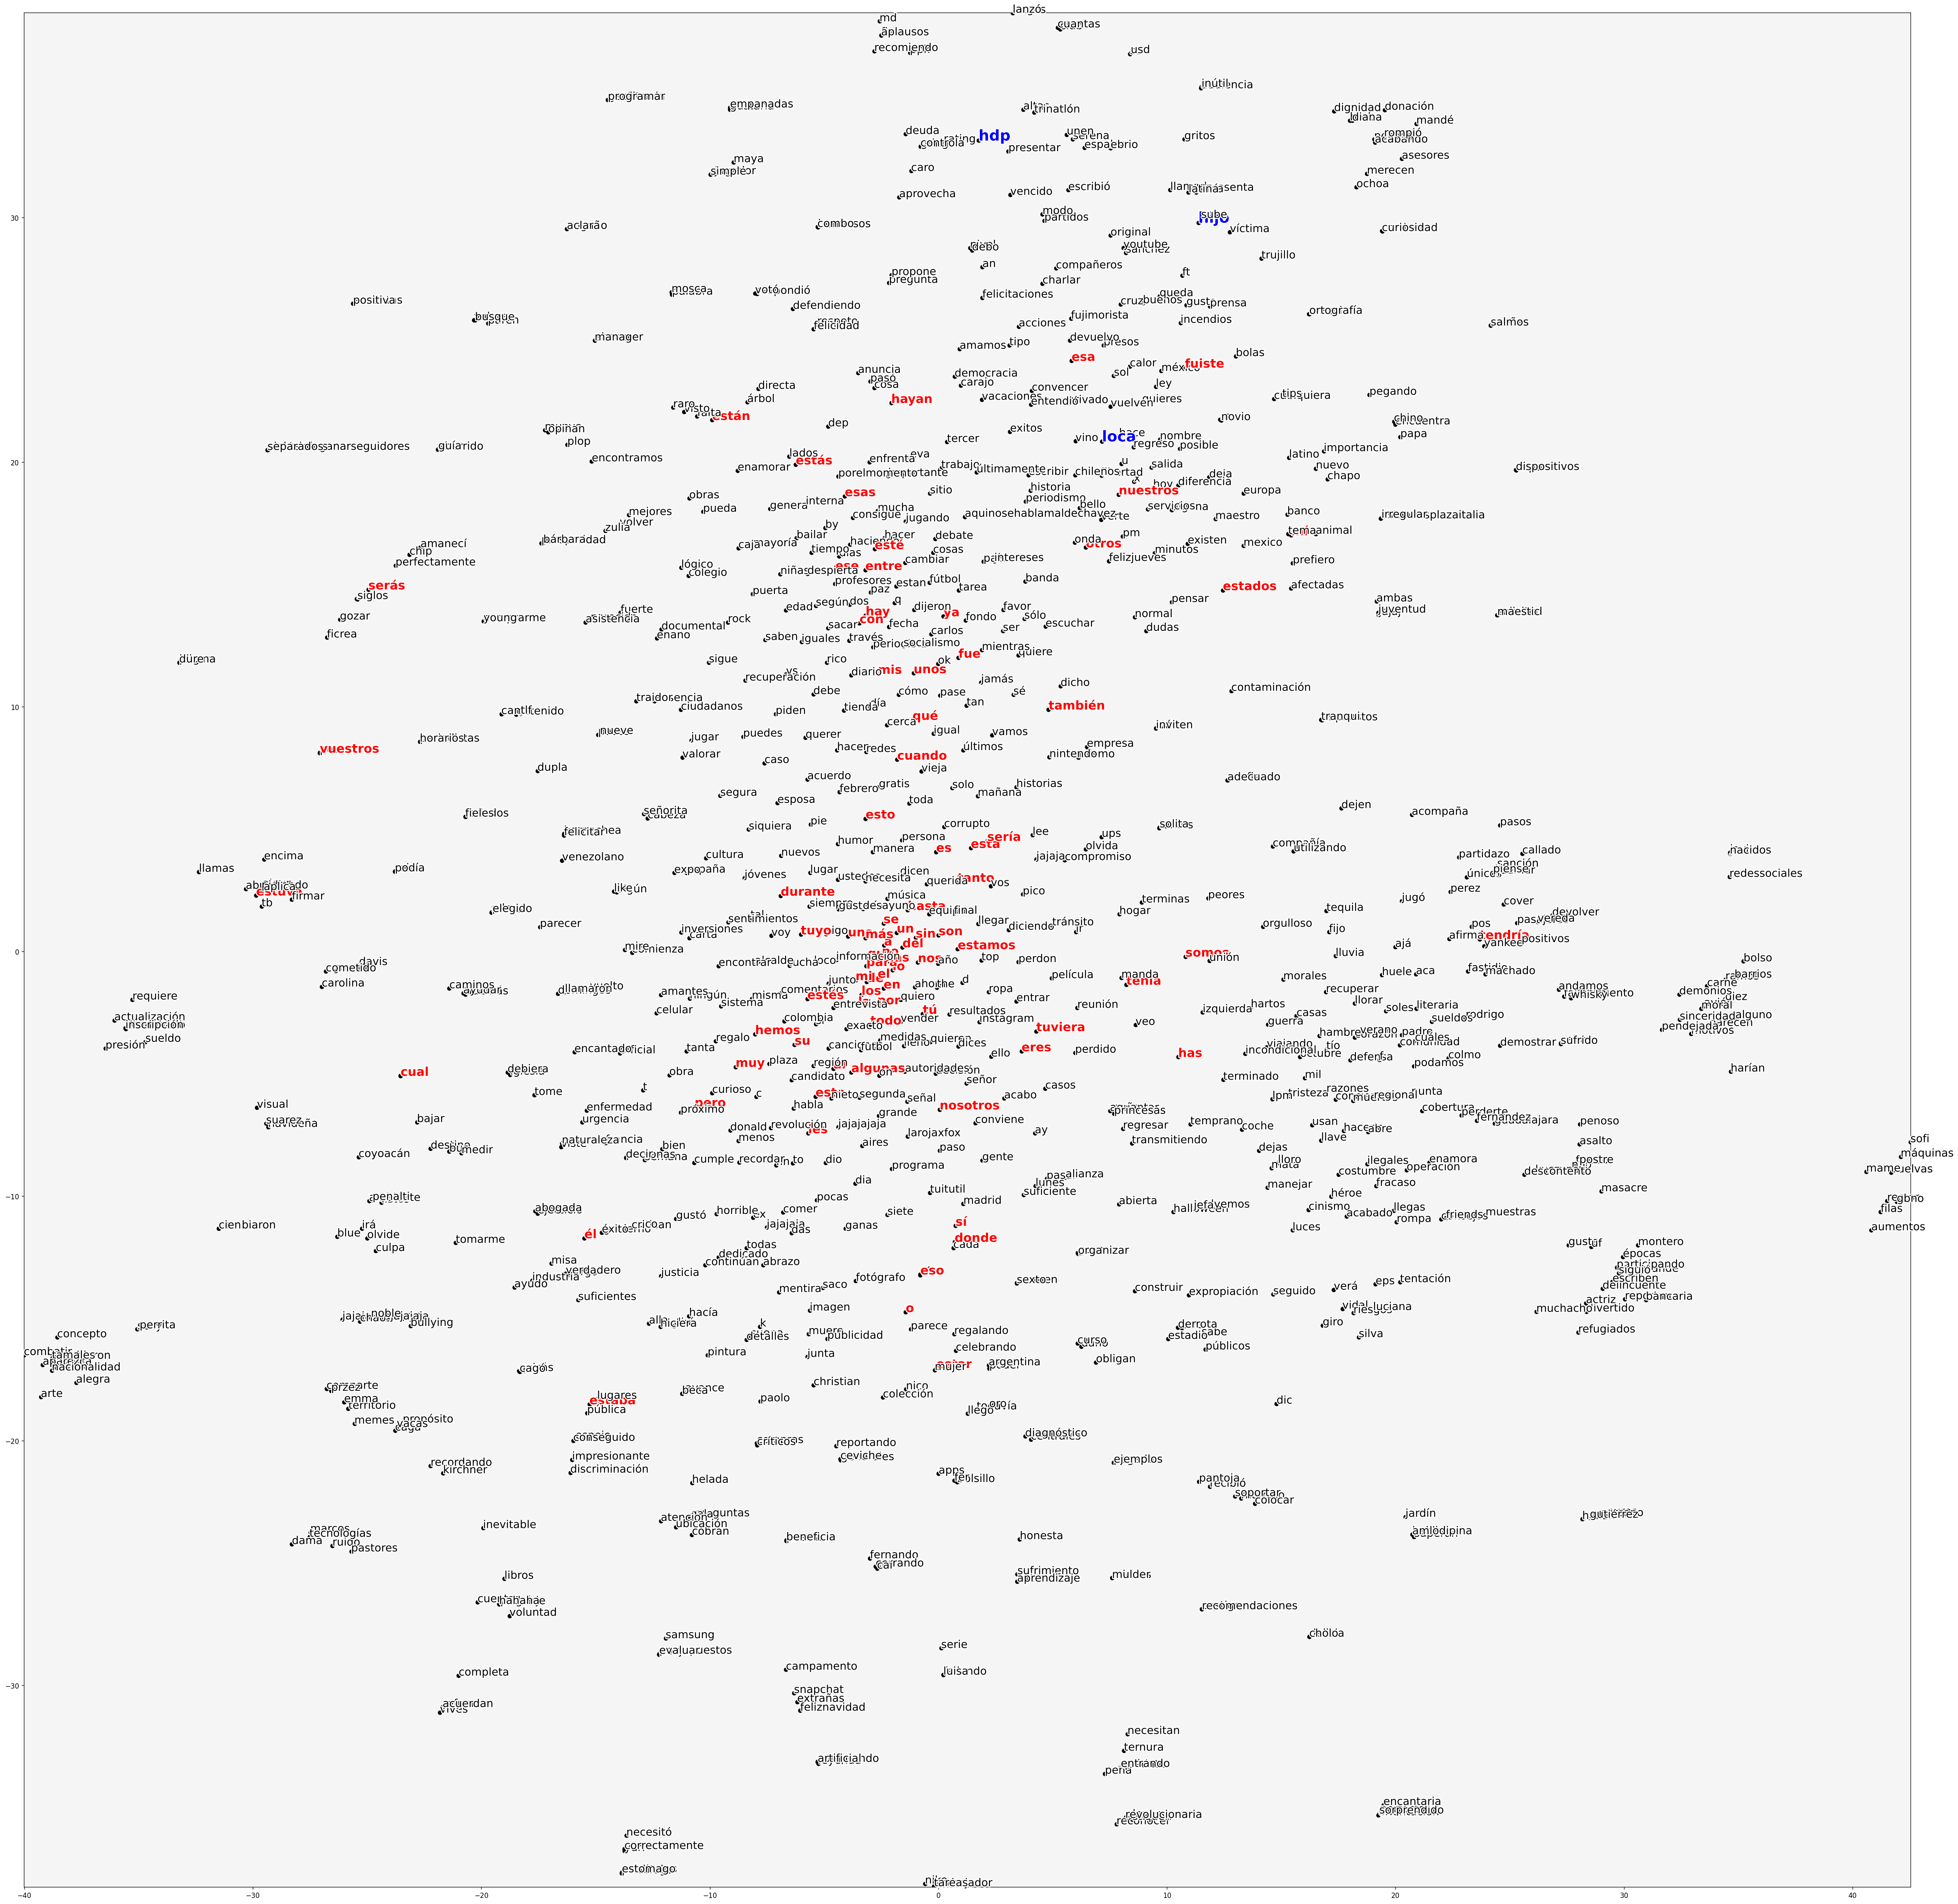

In [36]:
from matplotlib import patheffects
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')


sw = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in sw:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()


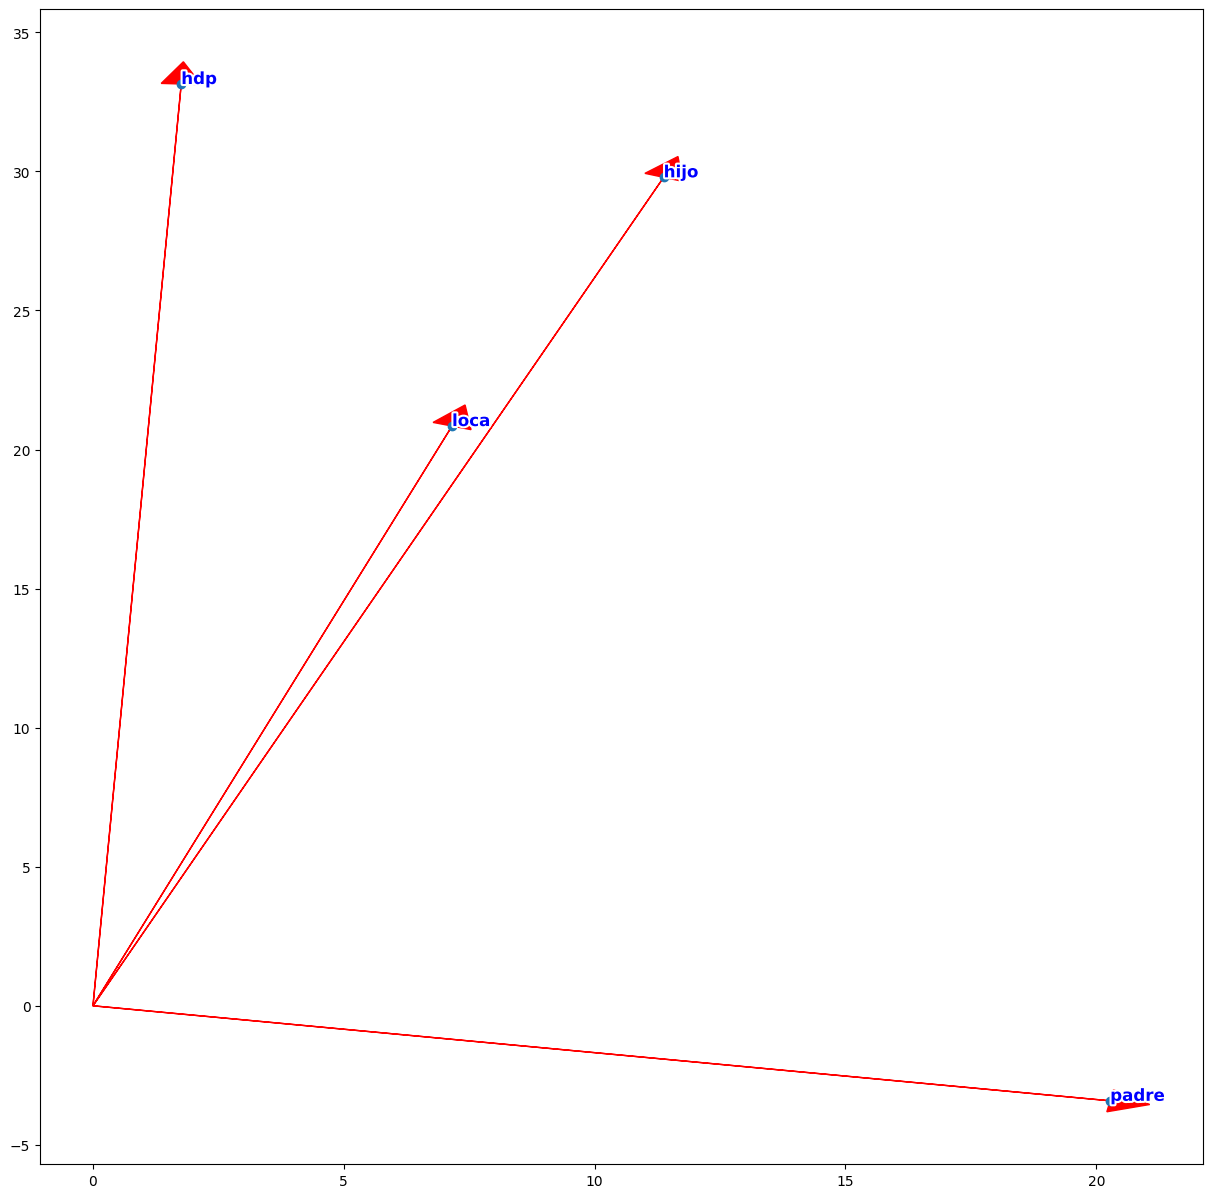

In [37]:
subsetword = ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía','padre','papá']

# t_words Las 1,000 mejores palabras según chi2 ( Algoritmo de selección de características)
# reduce_matriz Aquí estan las 1,000 mejores palabras en dos dimensiones

subreduce_matriz = []
ploted_subsetwords = []


for idx, word in enumerate(t_words):
    if word in subsetword:
        subreduce_matriz.append(reduce_matrix[idx])
        ploted_subsetwords.append(word)

print()

# Convertir a numpy array
subreduce_matriz = np.array(subreduce_matriz)


# Hacemos la gráfica de flechas
fig , ax = plt.subplots(figsize=(15, 15))

for word in subreduce_matriz:
    ax.arrow(0, 0, word[0], word[1], head_width=0.8, head_length=0.8, fc='red', ec='red', width=0.1e-2)
    ax.annotate(
        ploted_subsetwords[subreduce_matriz.tolist().index(word.tolist())], 
        (word[0], word[1]), 
        fontsize=12, 
        color='blue', 
        fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
    )

ax.scatter(subreduce_matriz[:,0], subreduce_matriz[:,1])

In [38]:
%pip install wordcloud
from wordcloud import WordCloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
chi2_scores = feats.scores_ 
best_scores = chi2_scores[best]

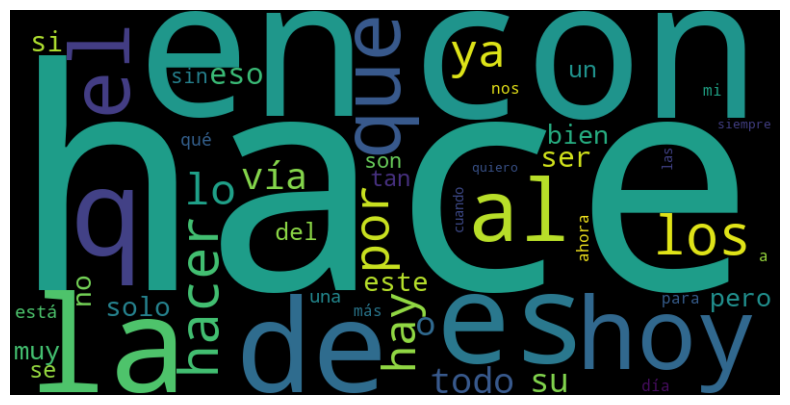

In [40]:
# Chi2
best_dict = {}
for palabra, indice in dict_indices.items():
    if indice in best[:50]:   
        best_dict[palabra] = chi2_scores[indice]  
top50 = dict(sorted(best_dict.items(), key=lambda x: x[1], reverse=True)[:50])

# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top50)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
